<a href="https://colab.research.google.com/github/serikkk84/practicum/blob/main/tariff%20recommendation/%D0%A0%D0%B5%D0%BA%D0%BE%D0%BC%D0%B5%D0%BD%D0%B4%D0%B0%D1%86%D0%B8%D1%8F%20%D1%82%D0%B0%D1%80%D0%B8%D1%84%D0%BE%D0%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Рекомендация тарифов

В нашем распоряжении данные о поведении клиентов. Нужно построить модель для задачи классификации, которая выберет подходящий тариф. 

Необходимо постройть модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов на тестовой выборке по крайней мере до 0.75. 

## Откроем и изучим файл

Импортируем библиотеки


In [ ]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from joblib import dump

Загрузим и посмотрим базу данных.

In [ ]:
try:
    df_calls = pd.read_csv('users_behavior.csv')
except:
    df_calls = pd.read_csv('/datasets/users_behavior.csv')
df_calls

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
...,...,...,...,...,...
3209,122.0,910.98,20.0,35124.90,1
3210,25.0,190.36,0.0,3275.61,0
3211,97.0,634.44,70.0,13974.06,0
3212,64.0,462.32,90.0,31239.78,0


Итак, мы имеем данные по услугам мобильного оператора для конкретного пользователя. Всего в базе данных 3214 строк - объектов и 5 колоннок, четыре из которых - признаки, а пятая - "is_ultra" - целевой признак, который обученная модель должна предсказывать. Также очевидно, что программа будет предсказывать категоральные данные (выберет ли клиент тариф ультра - 1, или нет - 0), поэтому изучим три модели обучения: решающее дерево (DecisionTreeClassifier), случайный лес (RandomForestClassifier) и  логистическая регрессия (LogisticRegression).

По условиям задачи предобработка данных не требуется, поэтому сразу переходим к разделению выборки.

## Разобьем данные на выборки

Сначала отделим тестовую выборку от общего датасета в размере 20%

In [ ]:
df_train, df_test = train_test_split(df_calls, test_size=0.20, random_state=12345)

И проверим

In [ ]:
df_train, df_test 

(      calls  minutes  messages   mb_used  is_ultra
 348    77.0   522.65      14.0  19462.45         0
 1172  144.0  1031.79      99.0  40174.34         1
 2315   48.0   341.65       0.0  19000.02         0
 954    52.0   383.90      40.0  24574.82         0
 2918   77.0   445.00     100.0  10518.28         1
 ...     ...      ...       ...       ...       ...
 2817   12.0    86.62      22.0  36628.85         1
 546    65.0   458.46       0.0  15214.25         1
 382   144.0   906.18       0.0  25002.44         1
 2177   38.0   301.27      37.0  28914.24         1
 482   160.0  1084.05      95.0  36843.92         1
 
 [2571 rows x 5 columns],
       calls  minutes  messages   mb_used  is_ultra
 1415   82.0   507.89      88.0  17543.37         1
 916    50.0   375.91      35.0  12388.40         0
 1670   83.0   540.49      41.0   9127.74         0
 686    79.0   562.99      19.0  25508.19         1
 2951   78.0   531.29      20.0   9217.25         0
 ...     ...      ...       ...     

Теперь отделим валидационную. Чтобы программа заранеее не обучилась на готовых решениях, делить будем не первоначальный датафрейм, а 'df_train'. Так же возьмем 25%, чтобы валидационная выборка была равна тестовой, а их отношение к базовой соответствовала 3:1:1.

In [ ]:
df_train, df_valid = train_test_split(df_train, test_size=0.25, random_state=12345)

И проверим

In [ ]:
df_train, df_valid 

(      calls  minutes  messages   mb_used  is_ultra
 2656   30.0   185.07      34.0  17166.53         0
 823    42.0   290.69      77.0  21507.03         0
 2566   41.0   289.83      15.0  22151.73         0
 1451   45.0   333.49      50.0  17275.47         0
 2953   43.0   300.39      69.0  17277.83         0
 ...     ...      ...       ...       ...       ...
 1043  106.0   796.79      23.0  42250.70         1
 2132   18.0   117.80       0.0  10006.79         1
 1642   87.0   583.02       1.0  11213.97         0
 1495   63.0   408.68      63.0  24970.26         0
 510    83.0   597.83       0.0  16273.02         0
 
 [1928 rows x 5 columns],
       calls  minutes  messages   mb_used  is_ultra
 2699   71.0   512.53      27.0  15772.68         0
 242   183.0  1247.04     150.0  29186.41         1
 2854   34.0   246.06      31.0   8448.76         0
 1638   63.0   468.66       0.0  11794.34         0
 1632    4.0    19.85      28.0  13107.42         0
 ...     ...      ...       ...     

Все получилось корректно. Можно переходить к исследованию качества моделей

## Исследование моделей

### Решающее дерево

Разделим датафрейм на признаки - features, и целевой признак - target

In [ ]:
features_train = df_train.drop(['is_ultra'], axis=1)
target_train = df_train['is_ultra']
features_valid = df_valid.drop(['is_ultra'], axis=1)
target_valid = df_valid['is_ultra']

Обучим решающее дерево на тренировачном фрейме и посмотрим его аккуратность меняя уровень глубины дерева от 1 до 27

In [ ]:
Depth= []
Accuracy = []
for depth in range(1,27): 
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    Depth.append(depth)
    Accuracy.append(accuracy_score(target_valid, predictions_valid))
    print("max_depth =", depth, ": ", end='')
    print(accuracy_score(target_valid, predictions_valid)) 
df_tree = pd.DataFrame(Accuracy, Depth)
print(df_tree)

max_depth = 1 : 0.7387247278382582
max_depth = 2 : 0.7573872472783826
max_depth = 3 : 0.7651632970451011
max_depth = 4 : 0.7636080870917574
max_depth = 5 : 0.7589424572317263
max_depth = 6 : 0.7573872472783826
max_depth = 7 : 0.7744945567651633
max_depth = 8 : 0.7667185069984448
max_depth = 9 : 0.7620528771384136
max_depth = 10 : 0.7713841368584758
max_depth = 11 : 0.7589424572317263
max_depth = 12 : 0.7558320373250389
max_depth = 13 : 0.749611197511664
max_depth = 14 : 0.7573872472783826
max_depth = 15 : 0.7527216174183515
max_depth = 16 : 0.749611197511664
max_depth = 17 : 0.7387247278382582
max_depth = 18 : 0.7418351477449455
max_depth = 19 : 0.7356143079315708
max_depth = 20 : 0.7293934681181959
max_depth = 21 : 0.7325038880248833
max_depth = 22 : 0.71850699844479
max_depth = 23 : 0.7293934681181959
max_depth = 24 : 0.7262830482115086
max_depth = 25 : 0.7293934681181959
max_depth = 26 : 0.7231726283048211
           0
1   0.738725
2   0.757387
3   0.765163
4   0.763608
5   0.758942

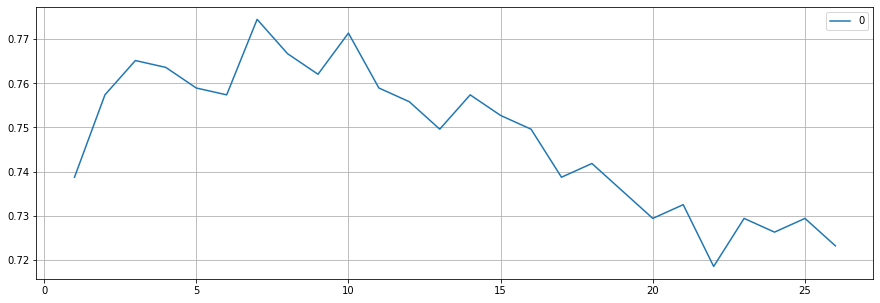

In [ ]:
import matplotlib.pyplot as plt
df_tree.plot(figsize=(15, 5))
plt.grid();

Не высокий уровень accuracy на всех уровнях решающего дерева. За лучший вариант возьмем модель с глубиной дерева -7.

### Случайный лес

Попробуем обучить модель используя 'случайный лес' с числом деревьев до 15.

In [ ]:
best_model = None
best_result = 0
for est in range(1, 16):
    model = RandomForestClassifier(random_state=12345, n_estimators=est) 
    model.fit(features_train, target_train) 
    result = model.score(features_valid, target_valid) 
    if result > best_result:
        best_model = model
        best_result = result 

print("Accuracy наилучшей модели на валидационной выборке:", best_result)
print("Лучшая модель на валидационной выборке:", best_model)

Accuracy наилучшей модели на валидационной выборке: 0.7884914463452566
Лучшая модель на валидационной выборке: RandomForestClassifier(n_estimators=10, random_state=12345)


Чуть усложним, изменив количество деревьев до 50 с шагом подбора равном 10, и подберем наилучшую глубину случайного леса установив параметр depth от 1 до 11

In [ ]:
best_model = None
best_result = 0
best_est = 0
best_depth = 0
for est in range(10, 51, 10):
    for depth in range (1, 11):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth) 
        model.fit(features_train, target_train) 
        predictions_valid = model.predict(features_valid) 
        result = model.score(features_valid, target_valid) 
        if result > best_result:
            best_model = model
            best_result = result
            best_est = est
            best_depth = depth

print("Accuracy  наилучшей модели на валидационной выборке:", best_result, "Количество деревьев:", best_est, "Максимальная глубина:", depth)

Accuracy  наилучшей модели на валидационной выборке: 0.7978227060653188 Количество деревьев: 50 Максимальная глубина: 10


Показатель аккуратности случайного леса выше, чем решающего дерева. Возьмем на данном этапе за лучшую модель случайный лес с количеством деревьев - 50 и максимальной глубиной -10.

### Логистическая регрессия

Обучим модель использую логистическую регрессию. Возьмем базовый алгоритм 'lbfgs', а колличество итераций обучения - 1000.

In [ ]:
model = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000) 

In [ ]:
model.fit(features_train, target_train) 
predictions = model.predict(features_valid)
print("Accuracy модели на валидационной выборке:", model.score(features_valid, target_valid))

Accuracy модели на валидационной выборке: 0.7262830482115086


Аккуратность обученой модели посредством логистической регрессий ниже чем у других.

## Проверка модели на тестовой выборке

Очевидно, наилучшая модель обучения, несмотря на довольно низкую скорость обработки данных, - это случайный лес с количеством деревьем 50 и максимальной глубиной 10. Проверим тестовую выборку на указанной моделе.

In [ ]:
features_test = df_test.drop(['is_ultra'], axis=1)
target_test = df_test['is_ultra']

model = RandomForestClassifier(random_state=12345, n_estimators=50, max_depth=10) 
model.fit(features_train, target_train) 
result = model.score(features_test, target_test) 
print("Accuracy наилучшей модели обученной библиотекой 'RandomForestClassifier'с количеством деревьев 50 и максимальной глубиной 10:", result)

Accuracy наилучшей модели обученной библиотекой 'RandomForestClassifier'с количеством деревьев 50 и максимальной глубиной 10: 0.7993779160186625


In [ ]:
df_new_train = df_train.append(df_valid, ignore_index=True)
df_new_train

,calls,minutes,messages,mb_used,is_ultra
0,30.0,185.07,34.0,17166.53,0
1,42.0,290.69,77.0,21507.03,0
2,41.0,289.83,15.0,22151.73,0
3,45.0,333.49,50.0,17275.47,0
4,43.0,300.39,69.0,17277.83,0
...,...,...,...,...,...
2566,83.0,539.32,33.0,20967.28,0
2567,80.0,552.33,23.0,18457.85,0
2568,111.0,899.74,0.0,26866.61,0
2569,68.0,493.00,29.0,20021.73,0


In [ ]:
features_new_train = df_new_train.drop(['is_ultra'], axis=1)
target_new_train = df_new_train['is_ultra']
features_test = df_test.drop(['is_ultra'], axis=1)
target_test = df_test['is_ultra']

model = RandomForestClassifier(random_state=12345, n_estimators=50, max_depth=10) 
model.fit(features_new_train, target_new_train) 
result = model.score(features_test, target_test) 
print("Accuracy наилучшей модели обученной библиотекой 'RandomForestClassifier'с количеством деревьев 50 и максимальной глубиной 10:", result)

Accuracy наилучшей модели обученной библиотекой 'RandomForestClassifier'с количеством деревьев 50 и максимальной глубиной 10: 0.7978227060653188


Не очень высокий показатель аккуратности, тем не менее выше минимально требуемого 0,75. 

## Вывод

Не смотря на довольно низкую скорость обработки данных, наилучшая обученная модель для решения поставленной задачи - это случайный лес с количеством деревьев равным 50, а макимальной глубиной равной десяти. Думаю, в данном случае это действительно лучшая модель, так как скоростью обработки можно пренебречь, по причине того что данная программа предназанчается для оператора, а не для пользования клиентами, для которых скорость является также приоритетным показателем на равне с аккуратностью предсказаний.